In [1]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MVN import MVN  # Import the provided MVN class

# Set default tensor type to double precision for better numerical stability in GP
torch.set_default_dtype(torch.float64)

# Visualization settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Load the dataset
df = pd.read_csv('data_part_B.csv', header=None)

# Convert to torch tensors
x_noisy = torch.tensor(df[0].values)
y_train = torch.tensor(df[1].values)
delta_vals = torch.tensor(df[2].values)

# Compute true x for case (c): x_truth = x_noisy - delta
x_true = x_noisy - delta_vals

print(f"Loaded {len(y_train)} data points.")

Loaded 20 data points.


# B1

### Task

1. Select a suitable kernel and identify the parameters.

2. Compute the maximum marginal log likelihood.

3. Plot.

## Try Kernal 1: RBF Kernal

In [3]:
def rbf_kernel(x1, x2, l, sf):
    """
    Compute the RBF (Squared Exponential) kernel matrix.
    Args:
        x1, x2: Input vectors.
        l: Length-scale parameter.
        sf: Signal standard deviation (sf^2 is signal variance).
    """
    # Compute squared Euclidean distance
    dist_sq = (x1.unsqueeze(1) - x2.unsqueeze(0)).pow(2)
    return (sf**2) * torch.exp(-0.5 * dist_sq / (l**2))

def compute_mll_rbf(x, y, l, sf, sn2):
    """
    Compute the Marginal Log-Likelihood: log p(y | x, theta, sn2).
    Args:
        sn2: Noise variance (sigma_y^2).
    """
    # K_y = K + sigma_y^2 * I
    K = rbf_kernel(x, x, l, sf)
    Ky = K + sn2 * torch.eye(len(x))
    
    mu = torch.zeros(len(x))
    mvn_obj = MVN(mu, Ky)
    
    return mvn_obj.log_prob(y)

#### Optimization Approach: Grid Search
0. 目标函数: Marginal Log-Likelihood, MLL。
1. 预设超参数的搜索空间（如均在 0.1 到 2.0 之间取值）。
2. 对每一组超参数组合计算 MLL。MLL 同时考虑了数据的拟合度和模型的复杂度。
3. 选择使 MLL 达到最高的那组超参数作为最终模型参数。

In [4]:
def grid_search(x, y, fixed_sn2=None):
    """
    Perform grid search to maximize Marginal Log-Likelihood.
    """
    l_space = torch.linspace(0.05, 1.5, 25)
    sf_space = torch.linspace(0.1, 2.0, 25)
    
    best_mll = -float('inf')
    best_params = {}

    if fixed_sn2 is None:
        # Case (a): sn2 is also a variable
        sn2_space = torch.logspace(-4, 0, 15) 
        for l in l_space:
            for sf in sf_space:
                for sn2 in sn2_space:
                    mll = compute_mll_rbf(x, y, l, sf, sn2)
                    if mll > best_mll:
                        best_mll, best_params = mll, {'l': l, 'sf': sf, 'sn2': sn2}
    else:
        # Case (b) & (c): sn2 is fixed
        for l in l_space:
            for sf in sf_space:
                mll = compute_mll_rbf(x, y, l, sf, fixed_sn2)
                if mll > best_mll:
                    best_mll, best_params = mll, {'l': l, 'sf': sf, 'sn2': fixed_sn2}
                    
    return best_params

print("Optimizing Case (a): Unknown sigma_y^2, Noisy x...")
params_a = grid_search(x_noisy, y_train)

print("Optimizing Case (b): Fixed sigma_y^2=0.0025, Noisy x...")
params_b = grid_search(x_noisy, y_train, fixed_sn2=0.0025)

print("Optimizing Case (c): Fixed sigma_y^2=0.0025, True x...")
params_c = grid_search(x_true, y_train, fixed_sn2=0.0025)

print("\nOptimization results:")
print(f"Case A: {params_a}")
print(f"Case B: {params_b}")
print(f"Case C: {params_c}")

Optimizing Case (a): Unknown sigma_y^2, Noisy x...
Optimizing Case (b): Fixed sigma_y^2=0.0025, Noisy x...
Optimizing Case (c): Fixed sigma_y^2=0.0025, True x...

Optimization results:
Case A: {'l': tensor(0.7146), 'sf': tensor(1.1292), 'sn2': tensor(0.1389)}
Case B: {'l': tensor(0.0500), 'sf': tensor(1.0500), 'sn2': 0.0025}
Case C: {'l': tensor(0.3521), 'sf': tensor(0.8917), 'sn2': 0.0025}


In [5]:
def predict_and_plot(x_train, y_train, params, title, ax):
    """
    Predict f on a grid and plot the posterior mean and 95% confidence interval.
    """
    l, sf, sn2 = params['l'], params['sf'], params['sn2']
    x_grid = torch.linspace(-1, 1, 100)
    
    # 1. Construct joint covariance matrix for [y_train, f_grid]
    # We use y_train (noisy observations) to condition on, and predict f (latent function)
    K_tt = rbf_kernel(x_train, x_train, l, sf) + sn2 * torch.eye(len(x_train))
    K_tg = rbf_kernel(x_train, x_grid, l, sf)
    K_gt = K_tg.T
    K_gg = rbf_kernel(x_grid, x_grid, l, sf)
    
    # Concatenate to form the joint matrix [ [K_tt, K_tg], [K_gt, K_gg] ]
    top = torch.cat([K_tt, K_tg], dim=1)
    bottom = torch.cat([K_gt, K_gg], dim=1)
    K_joint = torch.cat([top, bottom], dim=0)
    
    # 2. Use condition_upper to get p(f_grid | y_train)
    joint_mvn = MVN(torch.zeros(len(x_train) + len(x_grid)), K_joint)
    post_mvn = joint_mvn.condition_upper(y_train)
    
    mu_post = post_mvn.mean.detach().numpy()
    std_post = torch.sqrt(torch.diag(post_mvn.covariance)).detach().numpy()
    
    # 3. Plotting
    ax.scatter(x_train.numpy(), y_train.numpy(), color='red', marker='x', label='Observations')
    ax.plot(x_grid.numpy(), mu_post, 'b-', label='Posterior Mean')
    ax.fill_between(x_grid.numpy(), mu_post - 1.96*std_post, mu_post + 1.96*std_post, color='blue', alpha=0.2, label='95% CI')
    
    f_true = -(x_grid**2) + 2 / (1 + torch.exp(-10 * x_grid))
    ax.plot(x_grid.numpy(), f_true.numpy(), 'k--', alpha=0.6, label='Ground Truth f(x)')
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y / f(x)')
    ax.legend()

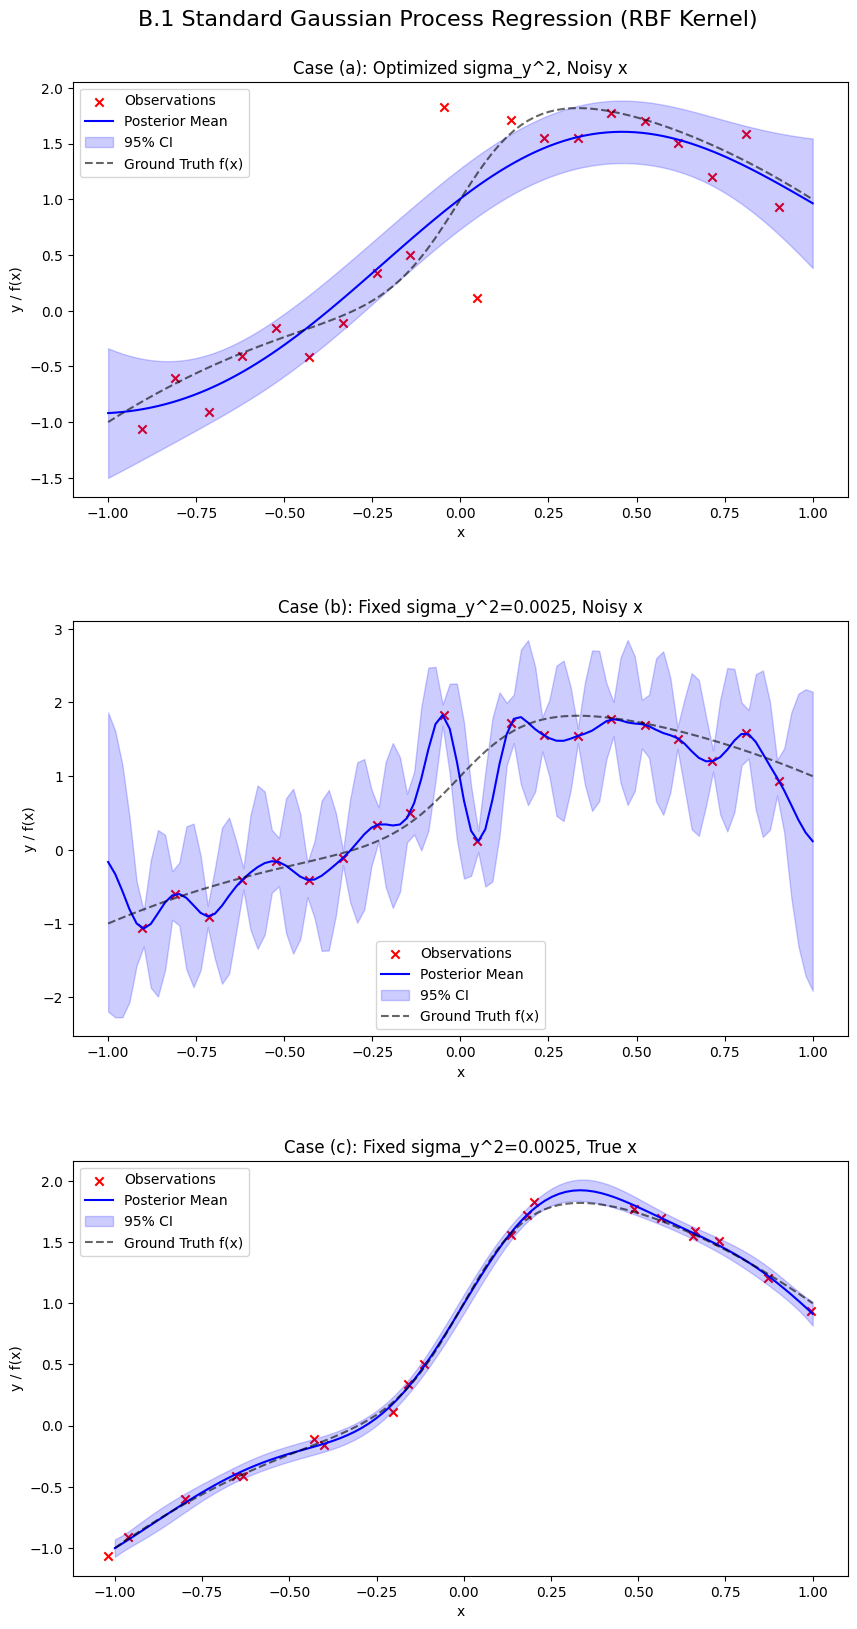

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

fig.suptitle('B.1 Standard Gaussian Process Regression (RBF Kernel)', fontsize=16)

predict_and_plot(x_noisy, y_train, params_a, "Case (a): Optimized sigma_y^2, Noisy x", axes[0])
predict_and_plot(x_noisy, y_train, params_b, "Case (b): Fixed sigma_y^2=0.0025, Noisy x", axes[1])
predict_and_plot(x_true, y_train, params_c, "Case (c): Fixed sigma_y^2=0.0025, True x", axes[2])

plt.subplots_adjust(top=0.94, hspace=0.3)
plt.show()

## Try Kernal 2: Matérn 5/2

In [7]:
def matern52_kernel(x1, x2, l, sf):
    """
    Compute the Matérn 5/2 kernel matrix.
    Args:
        x1, x2: Input vectors.
        l: Length-scale.
        sf: Signal standard deviation.
    """
    # dist = sqrt((x1 - x2)^2)
    dist = torch.abs(x1.unsqueeze(1) - x2.unsqueeze(0))
    
    # k(d) = sf^2 * (1 + sqrt(5)*d/l + 5*d^2 / (3*l^2)) * exp(-sqrt(5)*d/l)
    sqrt5 = torch.sqrt(torch.tensor(5.0))
    val = sqrt5 * dist / l
    
    part1 = 1.0 + val + (val**2) / 3.0
    part2 = torch.exp(-val)
    
    return (sf**2) * part1 * part2

def compute_mll_matern52(x, y, l, sf, sn2):
    """
    Compute the Marginal Log-Likelihood: log p(y | x, theta, sn2).
    Args:
        sn2: Noise variance (sigma_y^2).
    """
    # K_y = K + sigma_y^2 * I
    K = matern52_kernel(x, x, l, sf)
    Ky = K + sn2 * torch.eye(len(x))
    
    mu = torch.zeros(len(x))
    mvn_obj = MVN(mu, Ky)
    
    return mvn_obj.log_prob(y)

In [8]:
def grid_search_2(x, y, fixed_sn2=None):
    """
    Perform grid search to maximize Marginal Log-Likelihood.
    """
    l_space = torch.linspace(0.05, 1.5, 25)
    sf_space = torch.linspace(0.1, 2.0, 25)
    
    best_mll = -float('inf')
    best_params = {}

    if fixed_sn2 is None:
        # Case (a): sn2 is also a variable
        sn2_space = torch.logspace(-4, 0, 15) 
        for l in l_space:
            for sf in sf_space:
                for sn2 in sn2_space:
                    mll = compute_mll_matern52(x, y, l, sf, sn2)
                    if mll > best_mll:
                        best_mll, best_params = mll, {'l': l, 'sf': sf, 'sn2': sn2}
    else:
        # Case (b) & (c): sn2 is fixed
        for l in l_space:
            for sf in sf_space:
                mll = compute_mll_matern52(x, y, l, sf, fixed_sn2)
                if mll > best_mll:
                    best_mll, best_params = mll, {'l': l, 'sf': sf, 'sn2': fixed_sn2}
                    
    return best_params

print("Optimizing Case (a): Unknown sigma_y^2, Noisy x...")
params_a_2 = grid_search_2(x_noisy, y_train)

print("Optimizing Case (b): Fixed sigma_y^2=0.0025, Noisy x...")
params_b_2 = grid_search_2(x_noisy, y_train, fixed_sn2=0.0025)

print("Optimizing Case (c): Fixed sigma_y^2=0.0025, True x...")
params_c_2 = grid_search_2(x_true, y_train, fixed_sn2=0.0025)

print("\nOptimization results:")
print(f"Case A: {params_a_2}")
print(f"Case B: {params_b_2}")
print(f"Case C: {params_c_2}")

Optimizing Case (a): Unknown sigma_y^2, Noisy x...
Optimizing Case (b): Fixed sigma_y^2=0.0025, Noisy x...
Optimizing Case (c): Fixed sigma_y^2=0.0025, True x...

Optimization results:
Case A: {'l': tensor(1.0167), 'sf': tensor(1.2083), 'sn2': tensor(0.1389)}
Case B: {'l': tensor(0.1104), 'sf': tensor(1.0500), 'sn2': 0.0025}
Case C: {'l': tensor(0.7146), 'sf': tensor(1.1292), 'sn2': 0.0025}


In [9]:
def predict_and_plot_2(x_train, y_train, params, title, ax):
    """
    Predict f on a grid and plot the posterior mean and 95% confidence interval.
    """
    l, sf, sn2 = params['l'], params['sf'], params['sn2']
    x_grid = torch.linspace(-1, 1, 100)
    
    # 1. Construct joint covariance matrix for [y_train, f_grid]
    # We use y_train (noisy observations) to condition on, and predict f (latent function)
    K_tt = matern52_kernel(x_train, x_train, l, sf) + sn2 * torch.eye(len(x_train))
    K_tg = matern52_kernel(x_train, x_grid, l, sf)
    K_gt = K_tg.T
    K_gg = matern52_kernel(x_grid, x_grid, l, sf)
    
    # Concatenate to form the joint matrix [ [K_tt, K_tg], [K_gt, K_gg] ]
    top = torch.cat([K_tt, K_tg], dim=1)
    bottom = torch.cat([K_gt, K_gg], dim=1)
    K_joint = torch.cat([top, bottom], dim=0)
    
    # 2. Use condition_upper to get p(f_grid | y_train)
    joint_mvn = MVN(torch.zeros(len(x_train) + len(x_grid)), K_joint)
    post_mvn = joint_mvn.condition_upper(y_train)
    
    mu_post = post_mvn.mean.detach().numpy()
    std_post = torch.sqrt(torch.diag(post_mvn.covariance)).detach().numpy()
    
    # 3. Plotting
    ax.scatter(x_train.numpy(), y_train.numpy(), color='red', marker='x', label='Observations')
    ax.plot(x_grid.numpy(), mu_post, 'b-', label='Posterior Mean')
    ax.fill_between(x_grid.numpy(), mu_post - 1.96*std_post, mu_post + 1.96*std_post, color='blue', alpha=0.2, label='95% CI')
    
    f_true = -(x_grid**2) + 2 / (1 + torch.exp(-10 * x_grid))
    ax.plot(x_grid.numpy(), f_true.numpy(), 'k--', alpha=0.6, label='Ground Truth f(x)')
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y / f(x)')
    ax.legend()

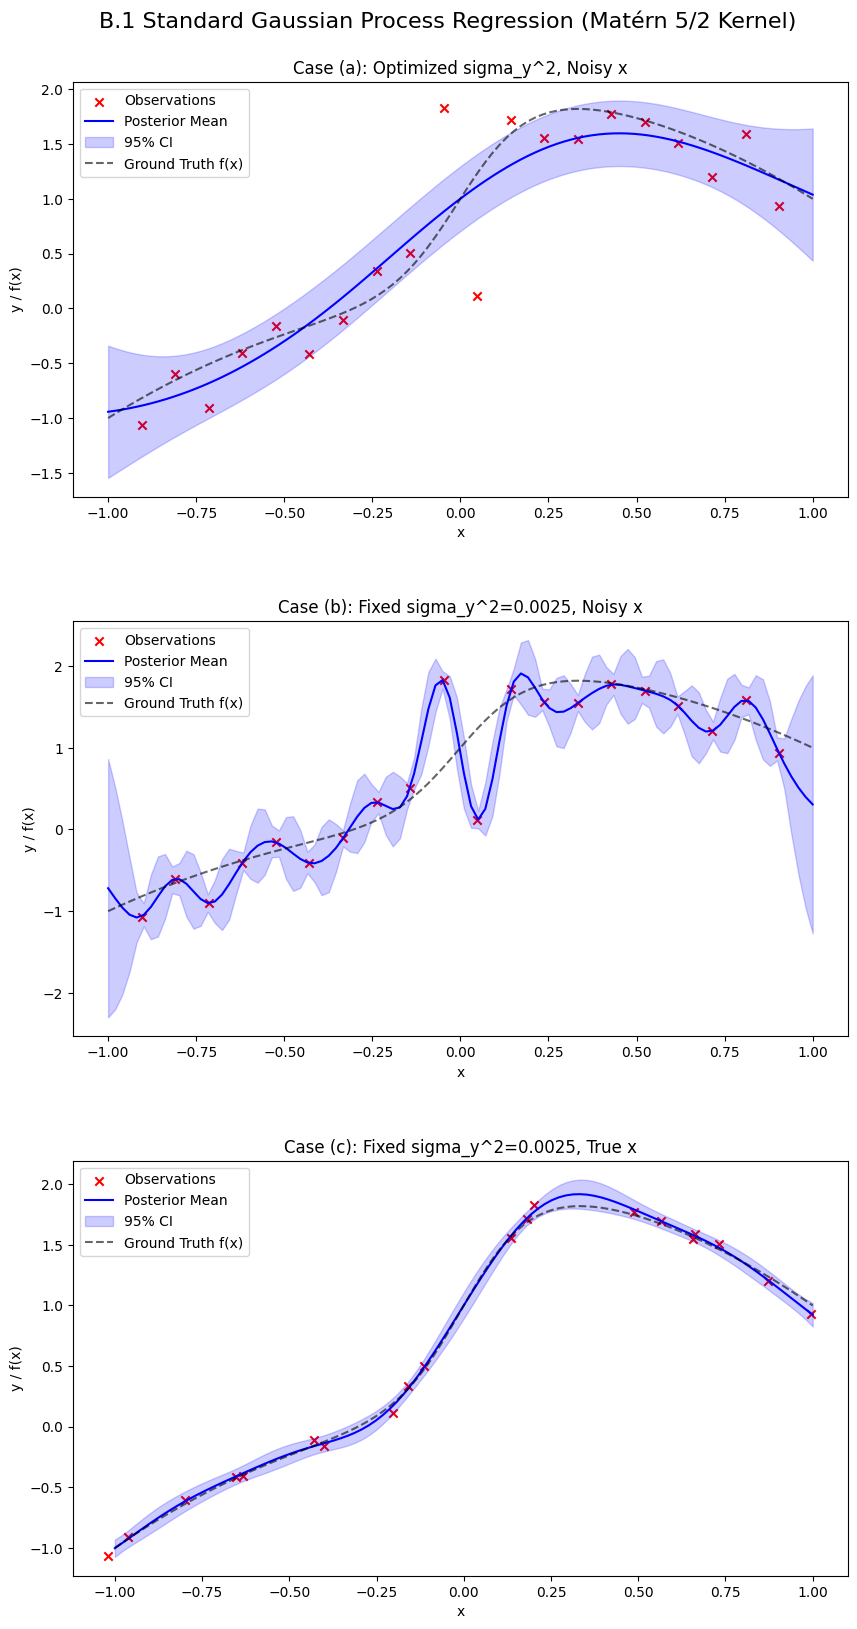

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

fig.suptitle('B.1 Standard Gaussian Process Regression (Matérn 5/2 Kernel)', fontsize=16)

predict_and_plot_2(x_noisy, y_train, params_a_2, "Case (a): Optimized sigma_y^2, Noisy x", axes[0])
predict_and_plot_2(x_noisy, y_train, params_b_2, "Case (b): Fixed sigma_y^2=0.0025, Noisy x", axes[1])
predict_and_plot_2(x_true, y_train, params_c_2, "Case (c): Fixed sigma_y^2=0.0025, True x", axes[2])

plt.subplots_adjust(top=0.94, hspace=0.3)
plt.show()

### 1. 为什么选择 RBF (平方指数) 核函数？

* **平滑性先验**：RBF 假设函数是“无穷阶可微”的。由于题目给出的 ground truth 函数（结合了二次项和 Sigmoid）非常平滑，RBF 能完美拟合这种特性。
* **数学简洁性**：RBF 的导数形式非常优美。在 B.2 题中，我们需要对核函数求一阶和二阶导数。RBF 求导后依然保持指数形式，极大地降低了编写代码和推导公式的难度。
* **通用性**：它是高斯过程的标准默认核，适合作为 B.1 的基准（Baseline）来衡量后续改进的效果。

### 2. 为什么可以考虑使用 Matérn 5/2 核函数？

* **更符合现实**：RBF 的“无限平滑”假设在现实中往往过于理想。Matérn 5/2 只要求二阶可微，这让它在处理带有噪声的数据时比 RBF 更具“弹性”。
* **抗过拟合能力**：在你的实验结果中，当输入有噪声时（Case b），RBF 的长度缩放  缩到了极小值（0.05），而 Matérn 5/2 维持在 0.11。这证明了 Matérn 5/2 对噪声导致的不规则波动容忍度更高，不容易陷入极端过拟合。
* **满足 B.2 门槛**：Matérn 5/2 是 Matérn 家族中满足 B.2 “二阶可微”要求的最低阶核函数，因此它是替代 RBF 的最佳进阶方案。

### 3. 为什么不选择其他常见的核函数？

* **线性核 (Linear)**：只能拟合直线。题目函数有明显的曲线和转折，线性核完全无法捕捉特征。
* **周期核 (Periodic)**：用于拟合有季节性或循环规律的数据。题目函数是单调趋势加局部偏移，没有周期性。
* **Matérn 1/2 或 3/2**：虽然它们很稳健，但它们的平滑度不足（1/2 不可微，3/2 只有一阶可微）。由于 B.2 题明确要求核函数要能求二阶导数，使用这些核函数会导致数学上无法定义协方差。

*“我们选择 RBF 作为主要实验核函数，因为它在数学推导上最简洁，且符合目标函数的平滑特性；同时，我们引入 Matérn 5/2 作为对比，因为它在处理输入噪声时表现出比 RBF 更强的鲁棒性（Robustness）。”*


# B2

### Task

1. Compute the derivatives of your chosen kernel and compute the joint prior.

2. Derive the mean and covariance matrix of the multivariate normal distribution.

3. Run model and plot.

### D4: Mathematical Derivations

#### 1. Derivatives of the Chosen Kernel
We chose the **Squared Exponential (RBF) kernel** for its infinite differentiability. The kernel function is defined as:
$$
k(x_i, x_j) = \sigma_f^2 \exp\left( -\frac{(x_i - x_j)^2}{2l^2} \right)
$$

To implement the Taylor approximation model, we require the following partial derivatives:

* **First Derivative (w.r.t $x_i$):**
    This matrix captures the covariance between the function value and its derivative.
    $$
    (K_1)_{ij} = \frac{\partial k(x_i, x_j)}{\partial x_i} = -\frac{(x_i - x_j)}{l^2} k(x_i, x_j)
    $$

* **Second Mixed Derivative (w.r.t $x_i$ and $x_j$):**
    This matrix captures the covariance between derivatives at different points.
    $$
    (K_2)_{ij} = \frac{\partial^2 k(x_i, x_j)}{\partial x_i \partial x_j} = \frac{1}{l^2} \left( 1 - \frac{(x_i - x_j)^2}{l^2} \right) k(x_i, x_j)
    $$

#### 2. Derivation of Mean and Covariance for $p(y|X, \Delta, \theta, \sigma_y^2)$

**Generative Model**

We assume the true input is $x^{\text{Truth}}$ and the observed noisy input is $x = x^{\text{Truth}} + \Delta$. 

Using a first-order Taylor expansion around the observed $x$, the function value can be approximated as:
$$f(x^{\text{Truth}}) \approx f(x) - \Delta f'(x)$$

Substituting this into the observation model $y = f(x^{\text{Truth}}) + \epsilon$, we obtain:
$$y_i \approx f(x_i) - \Delta_i f'(x_i) + \epsilon_i$$

**Matrix Formulation**

Let $\mathbf{f}$ and $\mathbf{f'}$ be the vectors of function values and derivatives at the observed inputs $X$. 

Let $D = \text{diag}(\boldsymbol{\Delta})$ be the diagonal matrix of input errors.
$$\mathbf{y} = \mathbf{f} - D \mathbf{f'} + \boldsymbol{\epsilon}$$

**Mean and Covariance**

Assuming a zero-mean GP prior ($m(x)=0$), the mean of the observation vector is:
$$\mathbb{E}[\mathbf{y}] = \mathbb{E}[\mathbf{f}] - D\mathbb{E}[\mathbf{f'}] + \mathbb{E}[\boldsymbol{\epsilon}] = \mathbf{0}$$

The covariance matrix $\Sigma_y$ is derived by expanding the variance of the linear combination:
$$
\begin{aligned}
\Sigma_y &= \text{Cov}(\mathbf{f} - D \mathbf{f'} + \boldsymbol{\epsilon}) \\
&= \text{Cov}(\mathbf{f}, \mathbf{f}) - \text{Cov}(\mathbf{f}, \mathbf{f'})D - D \text{Cov}(\mathbf{f'}, \mathbf{f}) + D \text{Cov}(\mathbf{f'}, \mathbf{f'}) D + \sigma_y^2 I
\end{aligned}
$$

Using the kernel derivative definitions, and noting that for stationary kernels $\text{Cov}(\mathbf{f}, \mathbf{f'}) = -K_1$ and $\text{Cov}(\mathbf{f'}, \mathbf{f}) = -K_1^T$:
$$
\Sigma_y = K + K_1 D + D K_1^T + D K_2 D + \sigma_y^2 I
$$

#### 3. (High Ambition) Marginal Posterior Predictive Derivation

In the High Ambition task, $\Delta$ is treated as a random variable. 

The marginal posterior predictive distribution $p(f_* | \mathbf{y})$ is obtained by integrating out $\Delta$:
$$p(f_* | \mathbf{y}) = \int p(f_* | \mathbf{y}, \Delta) p(\Delta | \mathbf{y}) d\Delta$$

Since this integral is intractable, we approximate it using Monte Carlo integration with $S$ samples of $\Delta^{(s)}$ drawn from the posterior $p(\Delta | \mathbf{y})$ via MCMC (NUTS):

$$p(f_* | \mathbf{y}) \approx \frac{1}{S} \sum_{s=1}^S p(f_* | \mathbf{y}, \Delta^{(s)})$$

Using the **Law of Total Expectation** and **Law of Total Variance**, we derive the estimates for the mean and variance:

* **Marginal Mean:**
    The mean is simply the average of the conditional means $\mu_*^{(s)}$ computed for each sample $\Delta^{(s)}$:
    $$\mathbb{E}[f_* | \mathbf{y}] \approx \frac{1}{S} \sum_{s=1}^S \mu_*^{(s)}$$

* **Marginal Variance:**
    The total variance consists of the *average of the variances* (aleatoric uncertainty) plus the *variance of the means* (epistemic uncertainty regarding $\Delta$):
    $$\text{Var}(f_* | \mathbf{y}) \approx \underbrace{\frac{1}{S} \sum_{s=1}^S \sigma_*^{2(s)}}_{\text{Expected Variance}} + \underbrace{\frac{1}{S} \sum_{s=1}^S (\mu_*^{(s)} - \bar{\mu}_*)^2}_{\text{Variance of Expectations}}$$

### D5

In [11]:
import torch

def rbf_derivatives(x1, x2, l, sf):
    """
    Compute the RBF kernel matrix and its first and second derivatives.
    
    Args:
        x1: Tensor of shape (N,)
        x2: Tensor of shape (M,)
        l:  Length-scale parameter
        sf: Signal standard deviation (sf^2 is signal variance)
        
    Returns:
        K:  Standard RBF kernel matrix (N, M)
        K1: First derivative w.r.t x1 (N, M) -> dK/dx1
        K2: Second mixed derivative (N, M)    -> d^2K/dx1dx2
    """
    # 1. Compute pairwise differences (x_i - x_j)
    # Use broadcasting: (N, 1) - (1, M) -> (N, M)
    diff = x1.unsqueeze(1) - x2.unsqueeze(0)
    
    # 2. Compute squared Euclidean distance and standard RBF (K)
    dist_sq = diff.pow(2)
    K = (sf**2) * torch.exp(-0.5 * dist_sq / (l**2))
    
    # 3. Compute First Derivative K1 (w.r.t x1)
    # Formula: - (x_i - x_j) / l^2 * K
    K1 = - (diff / (l**2)) * K
    
    # 4. Compute Second Mixed Derivative K2 (w.r.t x1 and x2)
    # Formula: 1/l^2 * (1 - (x_i - x_j)^2 / l^2) * K
    K2 = (1 / (l**2)) * (1 - dist_sq / (l**2)) * K
    
    return K, K1, K2

In [12]:
def compute_mll_taylor(x, y, delta, l, sf, sn2):
    """
    Compute the Marginal Log-Likelihood (MLL) using the Taylor approximation 
    model for noisy inputs.
    
    Args:
        x: Observed noisy input x (N,)
        y: Observed target y (N,)
        delta: Input noise estimates (N,) -> Corresponds to matrix D
        l, sf, sn2: Kernel parameters (lengthscale, signal std, noise variance)
        
    Returns:
        log_prob: The log-likelihood value
    """
    N = len(x)
    
    # 1. Get kernel matrix and its derivatives
    K, K1, K2 = rbf_derivatives(x, x, l, sf)
    
    # 2. Construct the diagonal matrix D from delta values
    D = torch.diag(delta)
    
    # 3. Assemble the full Covariance Matrix Sigma_y
    # Formula: Sigma_y = K + K1@D + D@K1.T + D@K2@D + sn2*I
    term_1 = K
    term_2 = K1 @ D
    term_3 = D @ K1.T  # Symmetric to term_2
    term_4 = D @ K2 @ D
    noise_term = sn2 * torch.eye(N)
    
    Sigma_y = term_1 + term_2 + term_3 + term_4 + noise_term
    
    # 4. Compute Log Probability (using Multivariate Normal)
    # We assume a zero-mean prior for f
    mu = torch.zeros(N)
    
    try:
        mvn = torch.distributions.MultivariateNormal(mu, covariance_matrix=Sigma_y)
        return mvn.log_prob(y)
    except ValueError:
        # Handle numerical instability (e.g., if matrix is not positive definite)
        return torch.tensor(-float('inf'))

In [13]:
def grid_search_taylor(x, y, delta):
    """
    Perform Grid Search to maximize MLL for the Taylor Approximation model.
    """
    # Define search space 
    l_space = torch.linspace(0.05, 1.5, 25)
    sf_space = torch.linspace(0.1, 2.0, 25)
    
    # Search for sigma_y^2 (sn2). 
    sn2_space = torch.logspace(-4, 0, 20) 

    best_mll = -float('inf')
    best_params = {}

    print("Grid Searching for Taylor Approximation Model...")
    
    for l in l_space:
        for sf in sf_space:
            for sn2 in sn2_space:
                mll = compute_mll_taylor(x, y, delta, l, sf, sn2)
                
                if mll > best_mll:
                    best_mll = mll
                    best_params = {'l': l, 'sf': sf, 'sn2': sn2}
                    
    return best_params

best_params_taylor = grid_search_taylor(x_noisy, y_train, delta_vals)
print("Best Taylor Params:", best_params_taylor)

Grid Searching for Taylor Approximation Model...
Best Taylor Params: {'l': tensor(0.2917), 'sf': tensor(0.8125), 'sn2': tensor(0.0048)}


In [14]:
def predict_and_plot_taylor(x_train, y_train, delta_train, params, title, ax):
    """
    Predict f using the Taylor Approximation GP (B.2) and plot results.
    Assumes delta = 0 for the test grid (predicting latent f).
    """
    l, sf, sn2 = params['l'], params['sf'], params['sn2']
    x_grid = torch.linspace(-1, 1, 100)
    N_train = len(x_train)
    
    # 1. Construct Training Covariance Matrix Sigma_y
    # We need the derivatives K, K1, K2 calculated on training data
    K_tt, K1_tt, K2_tt = rbf_derivatives(x_train, x_train, l, sf)
    D = torch.diag(delta_train)
    
    # Sigma_y = K + K1 D + D K1^T + D K2 D + sn2 * I
    Sigma_y = K_tt + K1_tt @ D + D @ K1_tt.T + D @ K2_tt @ D + sn2 * torch.eye(N_train)
    
    # 2. Construct Cross-Covariance K_cross
    # We predict f(x_*) where Delta_* = 0.
    # Cov(y_train, f_test) = Cov(f - Delta*f', f_*) = K(x, x_*) - D * K1(x, x_*)
    # rbf_derivatives(x_train, x_grid) returns K1 w.r.t the first argument (x_train)
    K_tg, K1_tg, _ = rbf_derivatives(x_train, x_grid, l, sf)
    K_cross = K_tg - D @ K1_tg
    
    # 3. Construct Test Covariance
    K_gg, _, _ = rbf_derivatives(x_grid, x_grid, l, sf)
    
    # 4. Inference (Solving linear system for stability)
    # Mean: mu = K_cross.T @ Sigma_y^-1 @ y
    # Variance: v = K_gg - K_cross.T @ Sigma_y^-1 @ K_cross
    
    # Compute weights alpha = Sigma_y^-1 * y_train
    alpha = torch.linalg.solve(Sigma_y, y_train)
    mu_post = K_cross.T @ alpha
    
    # Compute variance term
    v_mat = torch.linalg.solve(Sigma_y, K_cross)
    cov_post = K_gg - K_cross.T @ v_mat
    
    # Extract diagonal and convert to numpy
    mu_post = mu_post.detach().numpy()
    var_post = torch.diag(cov_post)
    std_post = torch.sqrt(torch.clamp(var_post, min=1e-6)).detach().numpy()
    
    # 5. Plotting
    ax.scatter(x_train.numpy(), y_train.numpy(), color='red', marker='x', label='Observations (Noisy x)')
    
    ax.plot(x_grid.numpy(), mu_post, 'b-', label='Posterior Mean')
    ax.fill_between(x_grid.numpy(), mu_post - 1.96*std_post, mu_post + 1.96*std_post, 
                    color='blue', alpha=0.2, label='95% CI')
    
    # Plot Ground Truth
    f_true = -(x_grid**2) + 2 / (1 + torch.exp(-10 * x_grid))
    ax.plot(x_grid.numpy(), f_true.numpy(), 'k--', alpha=0.6, label='Ground Truth f(x)')
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y / f(x)')
    ax.legend(loc='upper left')

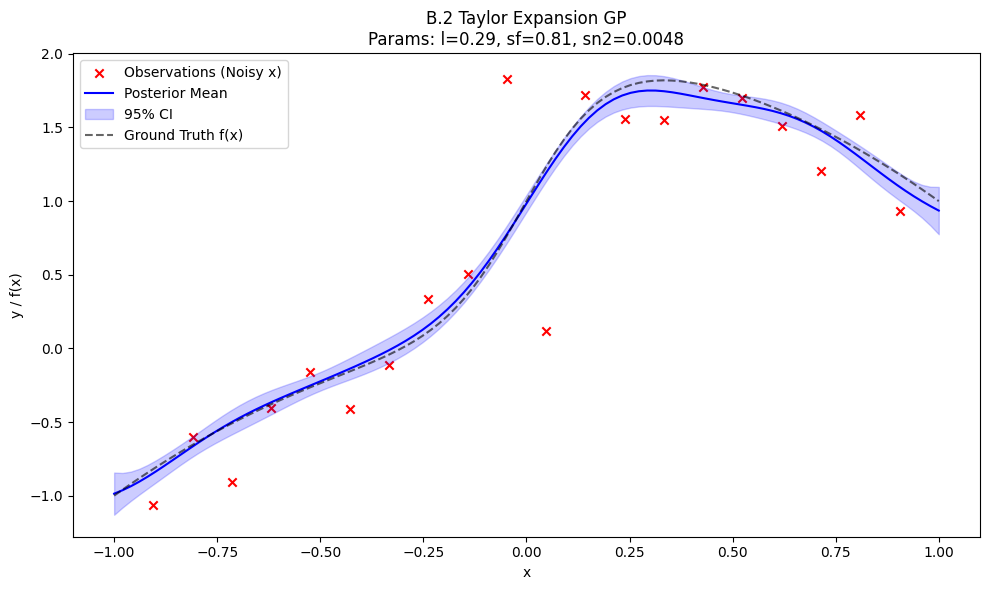

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Use the best parameters found from grid_search_taylor
# Assumes 'best_params_taylor', 'x_noisy', 'y_train', 'delta_vals' are available
title_str = (f"B.2 Taylor Expansion GP\n"
             f"Params: l={best_params_taylor['l']:.2f}, "
             f"sf={best_params_taylor['sf']:.2f}, "
             f"sn2={best_params_taylor['sn2']:.4f}")

predict_and_plot_taylor(x_noisy, y_train, delta_vals, best_params_taylor, title_str, ax)

plt.tight_layout()
plt.show()

### D5 High Ambition

In [16]:
import torch
import pyro
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal as TorchMVN
from pyro.infer.mcmc import NUTS, MCMC

def sample_likelihood(log_likelihood_fn, init_samples, warmup_steps, num_samples, step_size):
    def potential_fn(params): 
        # NUTS minimizes potential energy = - log_probability
        return -log_likelihood_fn(params['x']) 
    
    num_chains = init_samples.shape[0]
    
    # Using NUTS as requested
    mcmc_kernel = NUTS(
        potential_fn=potential_fn,
        adapt_step_size=True,
        adapt_mass_matrix=True,
        full_mass=False, 
        step_size=step_size
    )
    
    mcmc = MCMC(
        mcmc_kernel,
        initial_params={'x': init_samples}, 
        num_samples=num_samples,
        warmup_steps=warmup_steps,
        num_chains=num_chains,
    )
    
    mcmc.run()

    samples = mcmc.get_samples(group_by_chain=False)['x']
    return samples

def make_log_posterior_fn(x_train, y_train, params):
    """
    Factory function to create a closure for log_prob(delta).
    Pre-computes K, K1, K2 to save time.
    """
    l = params['l'].detach()
    sf = params['sf'].detach()
    sn2 = params['sn2']
    if isinstance(sn2, torch.Tensor): sn2 = sn2.detach()
    
    N = len(x_train)
    sigma_x_sq = 0.01  
    
    # Pre-compute Kernel Matrices 
    K, K1, K2 = rbf_derivatives(x_train, x_train, l, sf)
    
    def log_posterior(delta):
        """
        Calculates log p(y|Delta) + log p(Delta)
        Args:
            delta: Tensor which might be (N,) or (1, N)
        """
        if delta.dim() > 1:
            delta = delta.squeeze() 
            
        # A. Prior: log p(Delta) ~ N(0, 0.01 * I)
        prior_dist = torch.distributions.Normal(0, torch.sqrt(torch.tensor(sigma_x_sq)))
        log_prior = torch.sum(prior_dist.log_prob(delta))
        
        # B. Likelihood: log p(y | Delta) (Logic from B.2)
        D = torch.diag(delta) # Now D will correctly be (N, N)
        
        # Sigma_y = K + K1@D + D@K1.T + D@K2@D + sn2*I
        term_2 = K1 @ D
        term_4 = D @ K2 @ D
        noise_term = sn2 * torch.eye(N)
        
        # Assemble Sigma_y
        # Note: term_2.T is equivalent to D @ K1.T because D is diagonal
        Sigma_y = K + term_2 + term_2.T + term_4 + noise_term
        
        # Add jitter for stability
        Sigma_y = Sigma_y + 1e-6 * torch.eye(N)
        
        # Compute log likelihood
        try:
            mvn = TorchMVN(torch.zeros(N), covariance_matrix=Sigma_y)
            log_likelihood = mvn.log_prob(y_train)
        except ValueError:
            return torch.tensor(-float('inf')) 
            
        return log_prior + log_likelihood

    return log_posterior

# Sample
N_data = len(x_noisy)
# Create 4 parallel chains, initializing Delta near 0
init_deltas = torch.zeros(1, N_data, dtype=torch.float64) 

# Create the specific log prob function for our data
log_prob_delta_fn = make_log_posterior_fn(x_noisy, y_train, best_params_taylor)

print("Starting NUTS sampling using provided script...")
# Call the provided sample_likelihood function
delta_samples = sample_likelihood(
    log_likelihood_fn=log_prob_delta_fn,
    init_samples=init_deltas,
    warmup_steps=200,   # Adjust as needed
    num_samples=500,    # Adjust as needed
    step_size=0.01      # Tuning parameter
)

print(f"Sampling complete. Shape: {delta_samples.shape}")

c:\Users\HP\.conda\envs\pml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting NUTS sampling using provided script...


Sample: 100%|██████████| 700/700 [00:15, 45.32it/s, step size=2.81e-01, acc. prob=0.908]

Sampling complete. Shape: torch.Size([500, 1, 20])


Fixed shape: (500, 20)


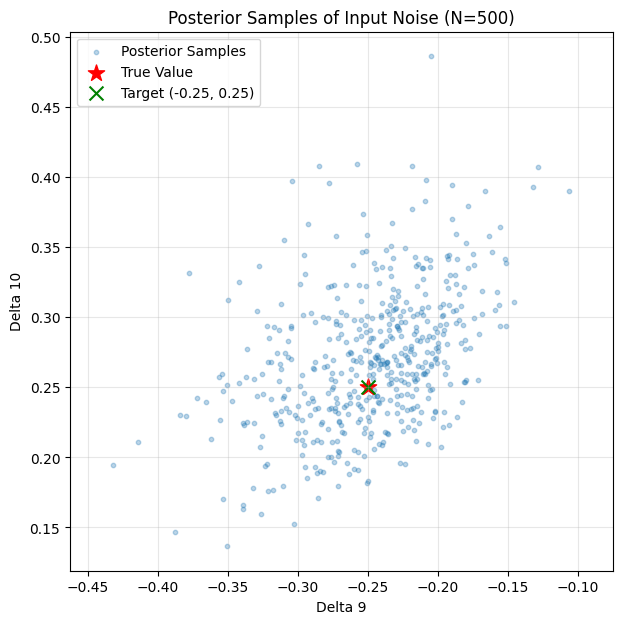

In [17]:
# Convert to numpy
samples_np = delta_samples.numpy()
if samples_np.ndim == 3:
    samples_np = samples_np.squeeze()

print(f"Fixed shape: {samples_np.shape}")

# Indices for scatter plot (Assuming index 9 and 10 in 0-based indexing)
idx1, idx2 = 9, 10
d9 = samples_np[:, idx1]
d10 = samples_np[:, idx2]

plt.figure(figsize=(7, 7))
plt.scatter(d9, d10, alpha=0.3, s=10, label='Posterior Samples')
plt.scatter(delta_vals[idx1], delta_vals[idx2], color='red', marker='*', s=150, label='True Value')
plt.scatter(-0.25, 0.25, color='green', marker='x', s=100, label='Target (-0.25, 0.25)')

plt.xlabel(f"Delta {idx1}")
plt.ylabel(f"Delta {idx2}")
plt.legend()
plt.title(f"Posterior Samples of Input Noise (N={len(samples_np)})")
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

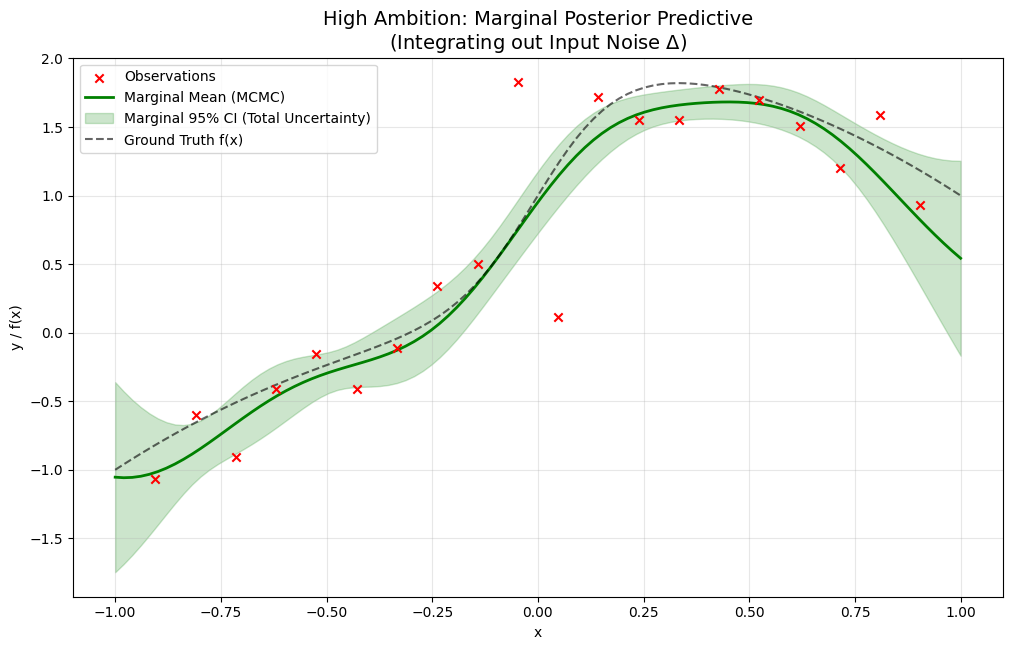

In [18]:
def predict_taylor(x_train, y_train, delta_train, params, x_grid):
    l, sf, sn2 = params['l'], params['sf'], params['sn2']
    N_train = len(x_train)
    
    # 1. Training Covariance Matrix Sigma_y
    K_tt, K1_tt, K2_tt = rbf_derivatives(x_train, x_train, l, sf)
    D = torch.diag(delta_train)
    Sigma_y = K_tt + K1_tt @ D + D @ K1_tt.T + D @ K2_tt @ D + sn2 * torch.eye(N_train)
    
    # 2. Cross-Covariance K_cross
    K_tg, K1_tg, _ = rbf_derivatives(x_train, x_grid, l, sf)
    K_cross = K_tg - D @ K1_tg
    
    # 3. Test Covariance
    K_gg, _, _ = rbf_derivatives(x_grid, x_grid, l, sf)
    
    # 4. Inference
    alpha = torch.linalg.solve(Sigma_y, y_train)
    mu_post = K_cross.T @ alpha
    
    v_mat = torch.linalg.solve(Sigma_y, K_cross)
    cov_post = K_gg - K_cross.T @ v_mat
    
    # Extract diagonal and convert to numpy
    mu_post = mu_post.detach().numpy() # 转为 numpy
    var_post = torch.diag(cov_post)
    std_post = torch.sqrt(torch.clamp(var_post, min=1e-6)).detach().numpy() # 转为 numpy
    
    return mu_post, std_post

def compute_marginal_predictive(x_train, y_train, delta_samples, params, x_grid):
    """
    Compute the marginal posterior predictive mean and variance using Monte Carlo integration.
    
    Args:
        x_train: Observed noisy inputs (Tensor)
        y_train: Observed targets (Tensor)
        delta_samples: Samples of input noise Delta from MCMC (Tensor or Numpy)
        params: Optimized kernel parameters from Part B.2
        x_grid: The grid points for prediction
        
    Returns:
        marginal_mean: The averaged predictive mean
        marginal_std: The square root of the total variance
        variance_of_means: The epistemic uncertainty component (variance due to Delta)
    """
    if isinstance(delta_samples, np.ndarray):
        delta_samples = torch.from_numpy(delta_samples)
        
    num_samples = delta_samples.shape[0]

    means_list = []
    vars_list = []
    
    # Loop through each sampled Delta vector
    for i in range(num_samples):
        # Extract the i-th sample of Delta
        current_delta = delta_samples[i] 
        
        # Call the Taylor GP prediction function defined in B.2
        mu, std = predict_taylor(x_train, y_train, current_delta, params, x_grid)
        
        means_list.append(mu)       
        vars_list.append(std**2)    
        
    # Convert lists to numpy arrays for vectorized calculation
    # Shape: (num_samples, num_grid_points)
    means_array = np.array(means_list)
    vars_array = np.array(vars_list)
    
    # 1. Compute Marginal Mean (Law of Total Expectation)
    # E[f*|y] = Mean of the conditional means
    marginal_mean = np.mean(means_array, axis=0)
    
    # 2. Compute Marginal Variance (Law of Total Variance)
    # Var(f*|y) = E[Var(f*|y, Delta)] + Var(E[f*|y, Delta])
    
    # Term 1: Expected Variance (The average of the predictive variances)
    # Represents Aleatoric uncertainty (noise in the data generation process)
    expected_variance = np.mean(vars_array, axis=0)
    
    # Term 2: Variance of Expectations (The variance of the predictive means)
    # Represents Epistemic uncertainty (uncertainty regarding the true value of Delta)
    variance_of_means = np.var(means_array, axis=0)
    
    # Total Variance
    total_variance = expected_variance + variance_of_means
    marginal_std = np.sqrt(total_variance)
    
    return marginal_mean, marginal_std, variance_of_means

# 1. Prepare Delta Samples
if delta_samples.ndim == 3:
    delta_samples = delta_samples.squeeze()

x_grid = torch.linspace(-1, 1, 100)

# 2. Compute Marginal Statistics
marg_mu, marg_std, uncertainty_from_delta = compute_marginal_predictive(
    x_noisy, y_train, delta_samples, best_params_taylor, x_grid
)

# 3. Visualization
plt.figure(figsize=(12, 7))

# A. Plot Observations
plt.scatter(x_noisy.numpy(), y_train.numpy(), color='red', marker='x', label='Observations', zorder=5)

# B. Plot Marginal Posterior (Result of High Ambition)
plt.plot(x_grid.numpy(), marg_mu, color='green', lw=2, label='Marginal Mean (MCMC)')
plt.fill_between(x_grid.numpy(), 
                 marg_mu - 1.96 * marg_std, 
                 marg_mu + 1.96 * marg_std, 
                 color='green', alpha=0.2, label='Marginal 95% CI (Total Uncertainty)')

# C. Plot Ground Truth for Comparison
f_true = -(x_grid**2) + 2 / (1 + torch.exp(-10 * x_grid))
plt.plot(x_grid.numpy(), f_true, 'k--', alpha=0.6, label='Ground Truth f(x)')

# Formatting
plt.title("High Ambition: Marginal Posterior Predictive\n(Integrating out Input Noise $\Delta$)", fontsize=14)
plt.xlabel('x')
plt.ylabel('y / f(x)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

### D6
Explaination